<a href="https://colab.research.google.com/github/florianrougier/pneumonia_detection/blob/master/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision applied to pneumonia detection




## Importing the dataset

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'xxxxxxxx'
os.environ['KAGGLE_KEY'] = 'xxxxxxxxxxxxx'

In [0]:
# Searching through the whole list of datasets
!kaggle datasets list -s pneumonia

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 98% 1.13G/1.15G [00:21<00:00, 35.7MB/s]
100% 1.15G/1.15G [00:21<00:00, 58.1MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip

In [0]:
!unzip chest_xray.zip -d chest-xray-pneumonia

In [0]:
# We now remove the zip files
!rm chest-xray-pneumonia.zip
!rm chest_xray.zip 

Note: We already have a train, a validation and a test folder

## Coding

Now it is time to do some coding. 

In [0]:
# Lets first install tensorflow 2.0.0.rc1
!pip install tensorflow-gpu==2.0.0.rc1

In [0]:
# We also install tqdm to get more information during the training
!pip install tqdm

## Stage 2: Dataset preprocessing

### Import project dependencies


In [0]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline
tf.__version__

'2.0.0-rc1'

In [0]:
# Now let's define the path to our train, validation and test directories
dataset_path = "./chest-xray-pneumonia/chest_xray/"

In [0]:
# We have 3 datasets: train, validation and test

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

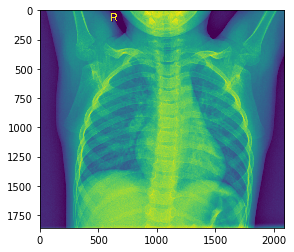

In [0]:
# Let's visualize some an example in the training set
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

Let's create a function to visualize a sample of images.

In [0]:
'''
Mandatory:
dataset: string, dataset from where we extract images
category: string, category within the dataset (NORMAL, PNEUMONIA)

Optional:
labeled: boolean, determine if images should be labeled
sample_size: int, number of images to display
'''
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  full_path = dataset_path + subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)


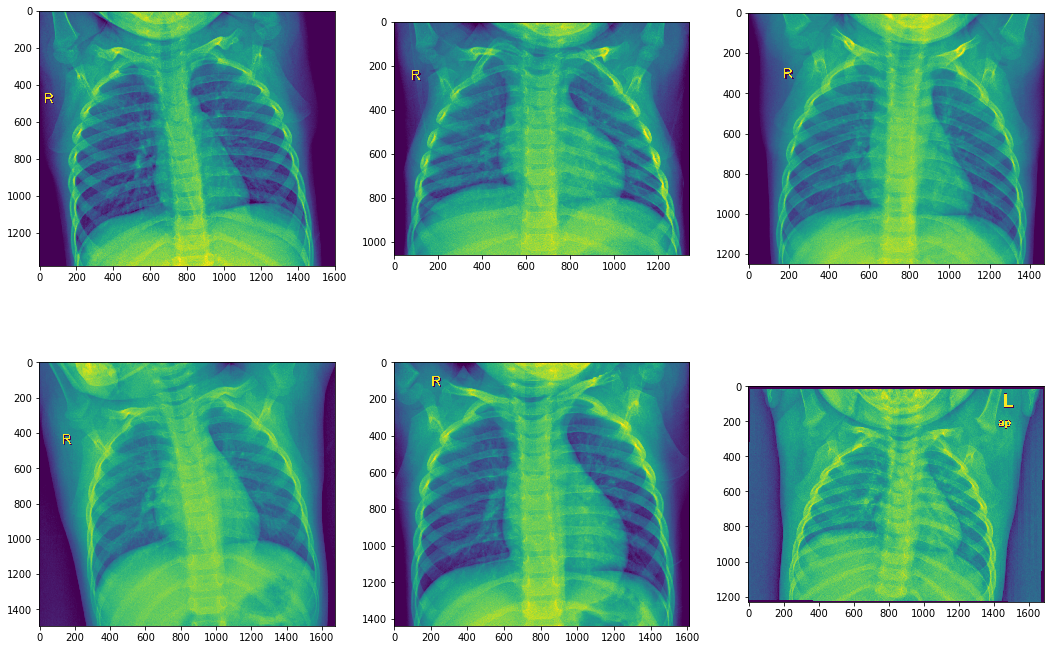

In [0]:
# Calling the above function
plot_img("train", "NORMAL")

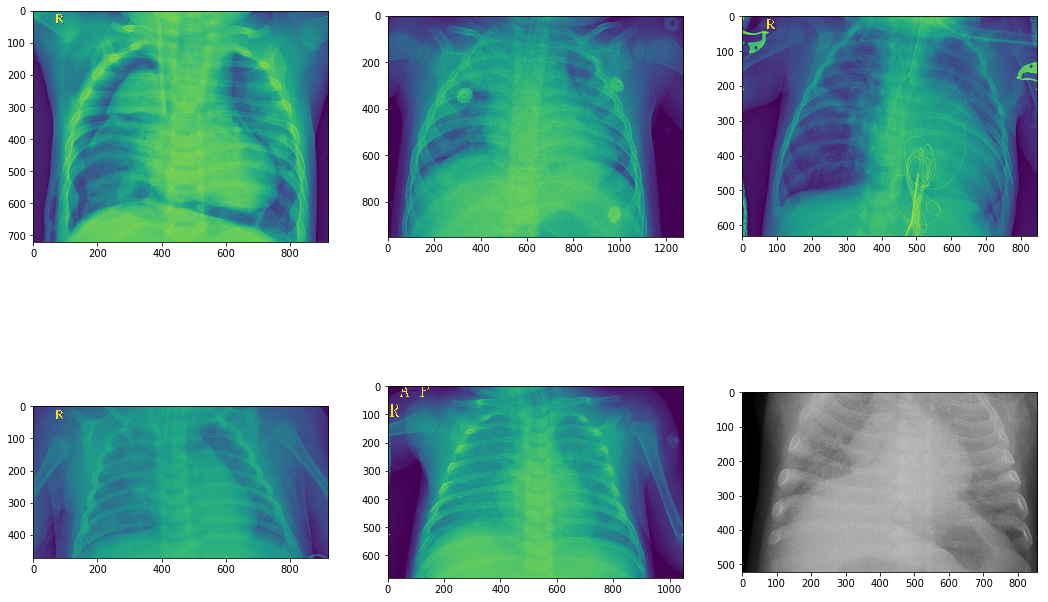

In [0]:
# With pneumonia cases
plot_img("train", "PNEUMONIA")

Now let's make a function to compare an image shwocasing pneumonia with another one which is normal

In [0]:
def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()

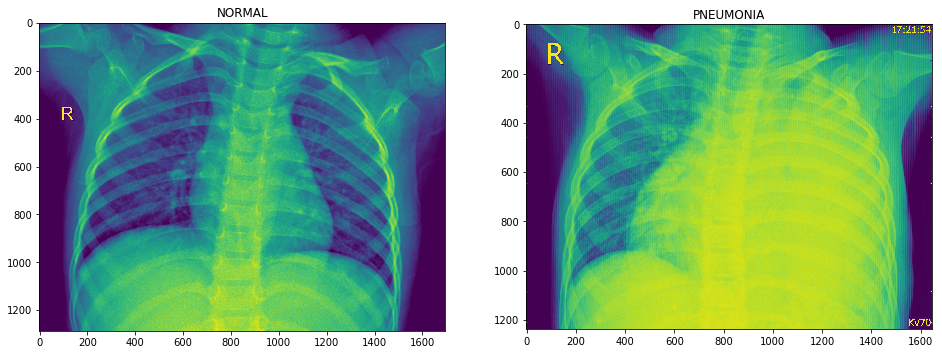

In [0]:
# Let's compare one image showasing pneumonia and one normal
compare_img("train", labeled = True)

## Building the model

### Loading the pre-trained model (InceptionV3)

In [0]:
IMG_SHAPE = (150, 150, 3)

In [0]:
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")

### Base architecture of the inceptionV3 model

In [0]:
base_model.summary() # This is quite a complex architecture

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Freezing the base model

In [0]:
base_model.trainable = False

### Defining the custom head for our network

In [0]:
base_model.output

<tf.Tensor 'mixed10/Identity:0' shape=(None, 3, 3, 2048) dtype=float32>

Using a pooling layer to reduce the output dimension

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [0]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Identity:0' shape=(None, 2048) dtype=float32>

In [0]:
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

### Defining the model

In [0]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compiling the model

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### Creating Data Generators

Resizing images

    Big pre-trained architecture support only certain input sizes.

For example: InceptionV3 (architecture that we use) supports: (150, 150)

In [0]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [0]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [0]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 16 images belonging to 2 classes.


In [0]:
test_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 624 images belonging to 2 classes.


### Training the model

Note: We don't have enough validation data.

Starting with 10 epochs, validation data showed overfitting, so i reduced the number of epochs to 5.

In [0]:
model.fit_generator(train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41/41 [==============================] - 75s 2s/step - loss: 0.5017 - accuracy: 0.7818 - val_loss: 0.8704 - val_accuracy: 0.6250
Epoch 2/5
41/41 [==============================] - 69s 2s/step - loss: 0.3279 - accuracy: 0.8714 - val_loss: 1.3702 - val_accuracy: 0.6250
Epoch 3/5
41/41 [==============================] - 69s 2s/step - loss: 0.2652 - accuracy: 0.8963 - val_loss: 1.1200 - val_accuracy: 0.7500
Epoch 4/5
41/41 [==============================] - 69s 2s/step - loss: 0.2346 - accuracy: 0.9055 - val_loss: 1.1254 - val_accuracy: 0.6875
Epoch 5/5
41/41 [==============================] - 69s 2s/step - loss: 0.2134 - accuracy: 0.9172 - val_loss: 2.1178 - val_accuracy: 0.6875


The model is still overfitting. We might want to increase the number of examples using data augmentation. (next step). The loss is still very high (validation loss).

### Transfer learning model evaluation

In [0]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [0]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.6875


### Plotting the results

The below function will compare the true values with the predicted ones using the validation which contains only 16 images (8 for both classes)

In [0]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    print(i, class_predicted[i])
    img = plt.imread(normal_path + normal_file)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 0 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.subplot(4, 4, 1 + i)
    plt.imshow(img)
      
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 0 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.subplot(4, 4, 9 + j)
    plt.imshow(img)


In [0]:
compare_results(validation_dir, valid_generator)

### Saving the model

In [0]:
import json
# serialize model to JSON
model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Fine tuning

There are a few pointers:

- DO NOT use Fine tuning on the whole network; only a few top layers are enough. In most cases, they are more specialized. The goal of the Fine-tuning is to adopt that specific part of the network for our custom (new) dataset.
- Start with the fine tunning AFTER you have finished with transfer learning step. If we try to perform Fine tuning immediately, gradients will be much different between our custom head layer and a few unfrozen layers from the base model. 

### Un-freeze a few top layers from the model

In [0]:
base_model.trainable = True

In [0]:
print("Number of layers in the base model: {}".format(len(base_model.layers)))

Number of layers in the base model: 311


In [0]:
# Defining the unfreezing starting point
fine_tune_at = 200

In [0]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compiling the model for fine tuning

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Fine tuning

In [0]:
model.fit_generator(generator = train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
41/41 [==============================] - 75s 2s/step - loss: 0.1395 - accuracy: 0.9467 - val_loss: 3.1078 - val_accuracy: 0.6250
Epoch 2/5
41/41 [==============================] - 74s 2s/step - loss: 0.0328 - accuracy: 0.9900 - val_loss: 6.9088 - val_accuracy: 0.5000
Epoch 3/5
41/41 [==============================] - 75s 2s/step - loss: 0.0136 - accuracy: 0.9944 - val_loss: 4.1265 - val_accuracy: 0.6250
Epoch 4/5
41/41 [==============================] - 75s 2s/step - loss: 0.0057 - accuracy: 0.9979 - val_loss: 4.9859 - val_accuracy: 0.6250
Epoch 5/5
41/41 [==============================] - 74s 2s/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 3.1902 - val_accuracy: 0.7500


### Evaluating the fine tuning

In [0]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [0]:
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

Validation accuracy after fine tuning: 0.75
